In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from astropy.table import Table
import astropy.units as u

In [2]:
import arya
import surp
from surp.gce_math import is_high_alpha
from surp._globals import DATA_DIR

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


Apogee can be downloaded from https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits, and astroNN from https://data.sdss.org/sas/dr17/env/APOGEE_ASTRO_NN/apogee_astroNN-DR17.fits.

In [3]:
filename = surp._globals.DATA_DIR + "allStar-dr17-synspec_rev1.fits.1"
da = Table.read(filename, format="fits", hdu=1)

'ancillary young embedded cluster member', 'ancillary emission line star', 'MIR-detected candidate cluster member (ancillary)', 

APOGEE2_Target3: 'Selected as part of the EB program', 'Selected as part of the young cluster study (IN-SYNC)', 'Ancillary W3/4/5 star forming complex'

              

Finally, I restrict to the given Log(g)-Teff domain:
log(g) ≥ 3.5
log(g) ≤ 0.004 ∗ (𝑇eff ) − 15.7
log(g) ≤ 0.00070588 ∗ (𝑇eff ) + 0.358836
log(g) ≤ −0.0015 ∗ (𝑇eff ) + 12.05
log(g) ≥ 0.0012 ∗ (𝑇eff ) − 2.8

In [4]:
apogee_target2 = 1<<17 #APOGEE_MIRCLUSTER_STAR
apogee_target2 ^= 1<<15 #APOGEE_EMISSION_STAR  emission line stars
apogee_target2 ^= 1<<13 #APOGEE_EMBEDDEDCLUSTER_STAR embedded cluster

In [5]:
apogee2_target3 = 1<<5 # young cluster (IN-SYNC)
apogee2_target3 ^= 1<<18 #APOGEE2_W345
apogee2_target3 ^= 1<<1 # EB planet

In [6]:
apogee_aspcapflag = 1<<23 # starbad
apogee_aspcapflag ^= 1<<31 # no_aspcap_result

In [7]:
mask = (da["APOGEE2_TARGET3"] & apogee2_target3) == 0
print(sum(~mask))
mask &= (da["APOGEE_TARGET2"] & apogee_target2) == 0
print(sum(~mask))

mask &= (da["ASPCAPFLAG"] & apogee_aspcapflag) == 0
print(sum(~mask))
print(sum(mask))

12470
16219
53604
680297


In [8]:
logg = da["LOGG"]
teff = da["TEFF"]

mask &= logg >= 3.5
mask &= logg <= 0.004*teff - 15.7
mask &= logg <= 0.000706*teff + 0.36
mask &= logg <= -0.0015 * teff + 12.05
mask &= logg >= 0.0012*teff - 2.8
print(sum(mask))

16412


In [9]:
mask &= ~da["FE_H"].mask
print(sum(mask))

mask &= ~da["MG_FE"].mask 
print(sum(mask))

mask &= ~da["C_FE"].mask
print(sum(mask))

mask &= ~da["C_FE_ERR"].mask
print(sum(mask))

mask &= ~da["FE_H_ERR"].mask
print(sum(mask))

mask &= ~da["MG_FE_ERR"].mask
print(sum(mask))

16406
16390
16365
16365
16365
16365


Jack's coordinates are

- (3.5, 4800)
- (3.8, 4875)
- (4.1, 5300)
- (3.8, 5500)
- (3.5, 5250)


In [10]:
coords = [
    (3.5, 4800),
    (3.8, 4875),
    (4.1, 5300),
    (3.8, 5500),
    (3.5, 5250),
    (3.5, 4800)
]
y = [c[0] for c in coords]
x = [c[1] for c in coords]

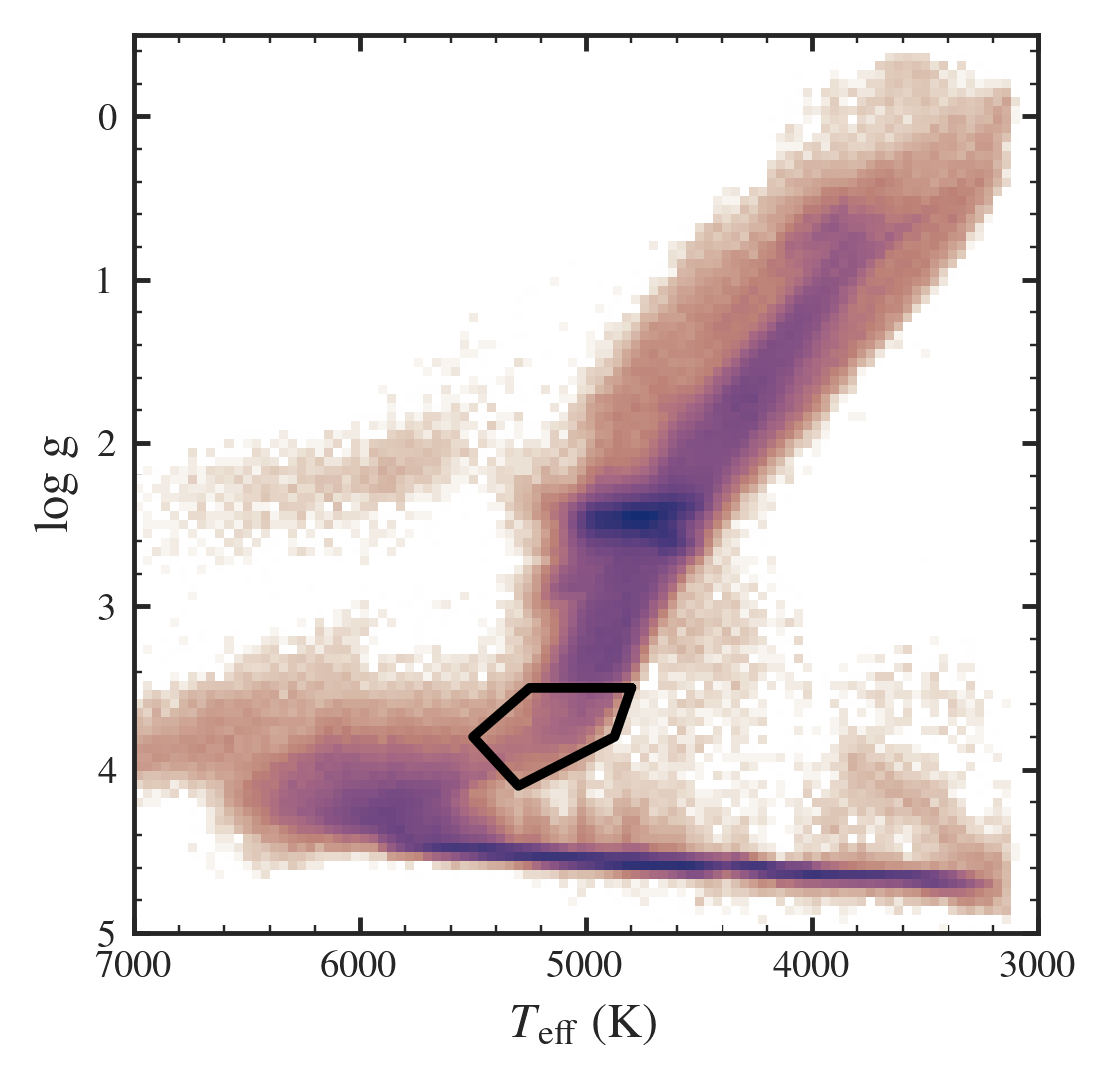

In [11]:
plt.figure(figsize=(10/3, 10/3), rasterized=True, dpi=350)
_, _, _, img = plt.hist2d(da["TEFF"], da["LOGG"], range=((3000, 7000), (-0.5, 5)), bins=100, norm="log", cmin=3, cmap=arya.style.get_cmap(to_white=True, reverse=True))
img.set_edgecolor("none")


plt.plot(x, y, lw=2, color="k")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("$T_{\\rm eff}$ (K)")
plt.ylabel("$\\log$ g")
plt.savefig("logg_jack.pdf")

In [12]:
# get rid of multdim columns
filtered = da[mask]
names = [name for name in filtered.colnames if len(filtered[name].shape) <= 1]
filtered = filtered[names].to_pandas()

del da

In [13]:
astroNN = Table.read(surp._globals.DATA_DIR + "apogee_astroNN-DR17.fits", format="fits", hdu=1)

names = [name for name in astroNN.colnames if len(astroNN[name].shape) <= 1]
astroNN = astroNN[names].to_pandas()

In [14]:
astroNN = astroNN[~astroNN["APOGEE_ID"].duplicated(keep="first")].copy()

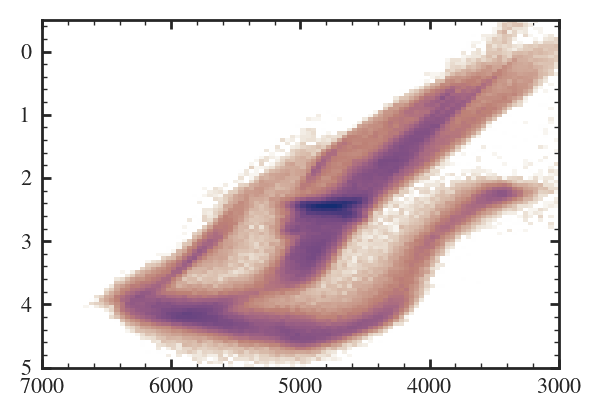

In [15]:
plt.hist2d(astroNN["TEFF"], astroNN["LOGG"], range=((3000, 7000), (-0.5, 5)), bins=100, norm="log", cmin=3, cmap=arya.style.get_cmap(to_white=True, reverse=True));

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [16]:
def bracket(df, ele, ele2="H"):
    """
    Helper function for subgiants()
    creates the abundance ratio [A/B]
    from the  APOGEE dataframe
    """
    if ele2 == "H":
        if ele == "FE":
            return df["FE_H"]
        else:
            return df["%s_FE" % ele] + df["FE_H"]
    else:
        if ele2 == "FE":
            return df["%s_FE" % ele]
        else:
            return df["%s_FE" % ele] - df["%s_FE" % ele2]


In [17]:
df = filtered
astroNN.set_index("APOGEE_ID", inplace=True)
astroNN.columns = astroNN.columns.map(lambda x: str(x) + '_ANN')

In [18]:
# Add useful abundance ratios
df["O_H"] = bracket(df, "O")
df["MG_H"] = bracket(df, "MG")
df["C_O"] = bracket(df, "C", "O")
df["C_MG"] = bracket(df, "C", "MG")
df["C_H"] = bracket(df, "C", "H")

df["C_N"] = bracket(df, "C", "N")
df["N_H"] = bracket(df, "N", "H")
df["N_O"] = bracket(df, "N", "O")
df["N_MG"] = bracket(df, "N", "MG")

df["FE_O"] = -df["O_FE"]
df["FE_MG"] = -df["MG_FE"]

df["C_MG_ERR"] = df["C_FE_ERR"] + df["MG_FE_ERR"]
df["N_MG_ERR"] = df["N_FE_ERR"] + df["MG_FE_ERR"]
df["C_N_ERR"] = df["N_FE_ERR"] + df["C_FE_ERR"]
df["MG_H_ERR"] = df["MG_FE_ERR"] + df["FE_H_ERR"]
df["C_H_ERR"] = df["C_FE_ERR"] + df["FE_H_ERR"]

# add high/low alpha column
df["high_alpha"] = is_high_alpha(df["MG_FE"], df.FE_H)


In [19]:

df = df.set_index("APOGEE_ID").join(astroNN).copy()
df["R_gal"] = df.galr_ANN
df["z_gal"] = df.galz_ANN

df["abs_z"] = np.abs(df.z_gal)

In [20]:
df.to_csv(DATA_DIR + "subgiants.csv")

In [21]:
del astroNN

In [22]:
import seaborn as sns

<Axes: xlabel='R_gal', ylabel='Density'>

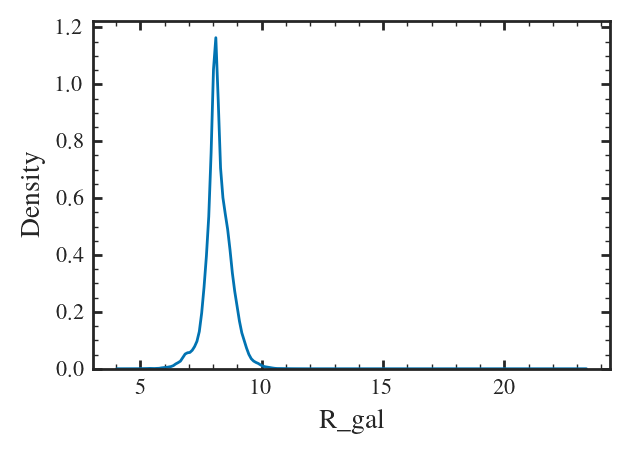

In [23]:
sns.kdeplot(df.R_gal)

In [24]:
pd.read_csv("../../data/subgiants.csv")

/tmp/slurmtmp.27749531/ipykernel_49167/1590072509.py:1: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("../../data/subgiants.csv")


,APOGEE_ID,FILE,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,...,theta_z_err_ANN,rl_ANN,rl_err_ANN,Energy_ANN,Energy_err_ANN,EminusEc_ANN,EminusEc_err_ANN,R_gal,z_gal,abs_z
0,b'2M00002185+1459100',b'apStar-dr17-2M00002185+1459100.fits',b'apo25m.107-46_MGA.2M00002185+1459100',b'apogee.apo25m.stars.107-46_MGA.2M00002185+14...,b'apogee.apo25m.synspec_fix.107-46_MGA.2M00002...,b'apo25m',2897,b'107-46_MGA',b'none',0.091079,...,0.007676,6.702875,0.035219,-47210.444135,96.223671,-55340.484688,63.233078,8.313700,-0.638698,0.638698
1,b'2M00004159+6505249',b'apStar-dr17-2M00004159+6505249.fits',b'apo25m.117+01.2M00004159+6505249',b'apogee.apo25m.stars.117+01.2M00004159+6505249',b'apogee.apo25m.synspec_fix.117+01.2M00004159+...,b'apo25m',4591,b'117+01',b'none',0.173321,...,0.003903,8.075501,0.015208,-40762.718004,29.143575,-54366.378175,79.540889,8.645126,0.070882,0.070882
2,b'2M00004251+5643075',b'apStar-dr17-2M00004251+5643075.fits',b'apo25m.NGC7789_btx.2M00004251+5643075',b'apogee.apo25m.stars.NGC7789_btx.2M00004251+5...,b'apogee.apo25m.synspec_fix.NGC7789_btx.2M0000...,b'apo25m',5922,b'NGC7789_btx',b'none',0.177160,...,0.037539,8.492589,0.062530,-38776.933977,324.414275,-53800.447966,118.707815,8.796458,-0.106140,0.106140
3,b'2M00005728+6958488',b'apStar-dr17-2M00005728+6958488.fits',b'apo25m.120+08.2M00005728+6958488',b'apogee.apo25m.stars.120+08.2M00005728+6958488',b'apogee.apo25m.synspec_fix.120+08.2M00005728+...,b'apo25m',4120,b'120+08',b'none',0.238695,...,0.000890,10.484267,0.012830,-29016.840979,71.242377,-49710.396879,39.627993,8.509211,0.120878,0.120878
4,b'2M00012854+7021553',b'apStar-dr17-2M00012854+7021553.fits',b'apo25m.120+08.2M00012854+7021553',b'apogee.apo25m.stars.120+08.2M00012854+7021553',b'apogee.apo25m.synspec_fix.120+08.2M00012854+...,b'apo25m',4120,b'120+08',b'none',0.368950,...,0.019339,6.871129,0.013222,-46751.884530,61.656360,-55630.271001,111.281571,8.983689,0.240327,0.240327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16360,b'2M23582628+5524124',b'apStar-dr17-2M23582628+5524124.fits',b'apo25m.N7789.2M23582628+5524124',b'apogee.apo25m.stars.N7789.2M23582628+5524124',b'apogee.apo25m.synspec_fix.N7789.2M23582628+5...,b'apo25m',4264,b'N7789',b'none',359.609541,...,0.033297,7.944538,0.020413,-42174.780917,102.357025,-55311.675705,28.850850,8.673670,-0.111265,0.111265
16361,b'2M23582727+5606296',b'apStar-dr17-2M23582727+5606296.fits',b'apo25m.N7789.2M23582727+5606296',b'apogee.apo25m.stars.N7789.2M23582727+5606296',b'apogee.apo25m.synspec_fix.N7789.2M23582727+5...,b'apo25m',4264,b'N7789',b'none',359.613632,...,0.023310,9.986815,0.007530,-32153.287018,42.057458,-51578.496096,22.353280,8.390348,-0.039268,0.039268
16362,b'2M23590547+1514580',b'apStar-dr17-2M23590547+1514580.fits',b'apo25m.107-46_MGA.2M23590547+1514580',b'apogee.apo25m.stars.107-46_MGA.2M23590547+15...,b'apogee.apo25m.synspec_fix.107-46_MGA.2M23590...,b'apo25m',2897,b'107-46_MGA',b'none',359.772796,...,0.007630,8.371702,0.003401,-40383.569866,12.284173,-55006.179535,3.209306,8.257049,-0.458691,0.458691
16363,b'2M23594577-7351233',b'asStar-dr17-2M23594577-7351233.fits',b'lco25m.SMC12.2M23594577-7351233',b'apogee.lco25m.stars.SMC12.2M23594577-7351233',b'apogee.lco25m.synspec_fix.SMC12.2M23594577-7...,b'lco25m',7218,b'SMC12',b'none',359.940730,...,705.417679,8.446436,2.023079,13934.370148,11914.926850,339.591786,7159.535159,23.141908,-25.227181,25.227181


In [4]:
df = surp.subgiants

(5.0, 11.0)

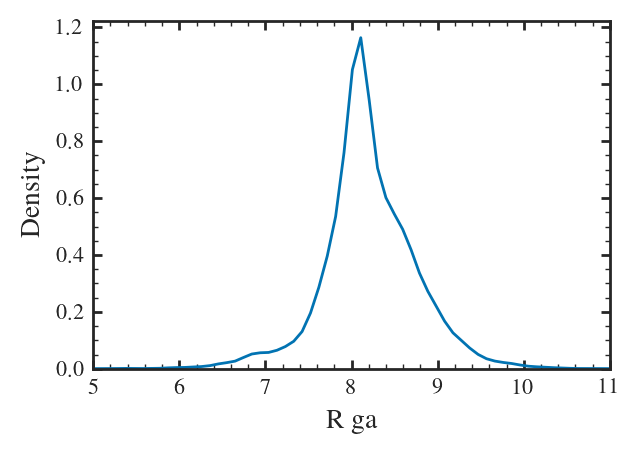

In [25]:
sns.kdeplot(df.R_gal)
plt.xlabel("R ga")
plt.xlim(5, 11)

# Comparison

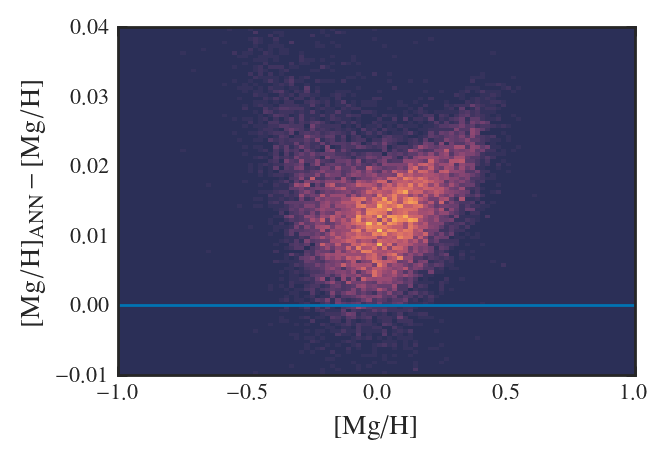

In [26]:
plt.hist2d(df.MG_H, df.MG_H_ERR_ANN - df.MG_H_ERR, 100, range=([-1, 1], [-0.01, 0.04]));
plt.xlabel("[Mg/H]")
plt.ylabel(r"$\rm [Mg/H]_{ANN} - [Mg/H]$")
plt.axhline(0)

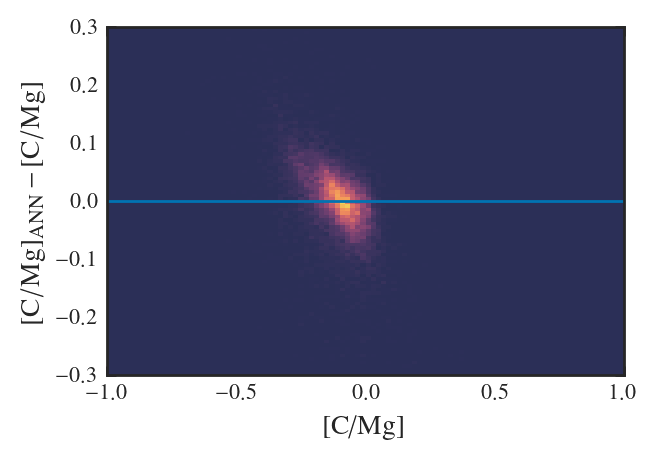

In [27]:
plt.hist2d(df.C_MG, df.C_H_ANN - df.MG_H_ANN - df.C_MG, 100, range=([-1, 1], [-0.3, 0.3]));
plt.xlabel("[C/Mg]")
plt.ylabel(r"$\rm [C/Mg]_{ANN} - [C/Mg]$")
plt.axhline(0)

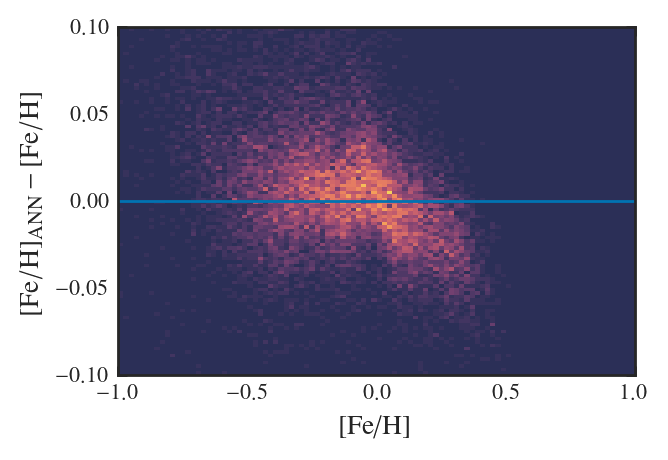

In [41]:
plt.hist2d(df.FE_H, df.FE_H_ANN - df.FE_H, 100, range=([-1, 1], [-0.1, 0.1]));
plt.xlabel("[Fe/H]")
plt.ylabel(r"$\rm [Fe/H]_{ANN} - [Fe/H]$")
plt.axhline(0)

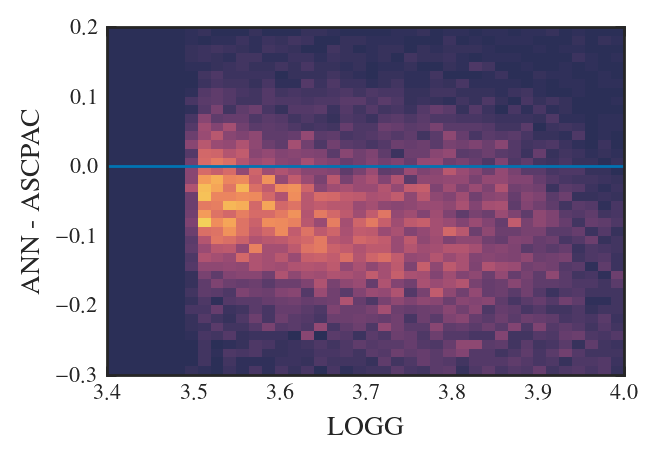

In [46]:
plt.hist2d(df.LOGG, df.LOGG_ANN - df.LOGG, 40, range=([3.4, 4], [-0.3, 0.2]));
plt.xlabel("LOGG")
plt.ylabel(r"ANN - ASCPAC")
plt.axhline(0)

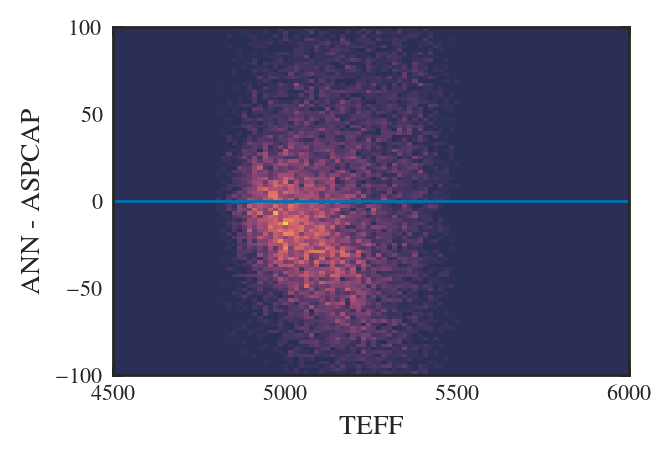

In [48]:
plt.hist2d(df.TEFF, df.TEFF_ANN - df.TEFF, 100, range=([4500, 6_000], [-100, 100]));
plt.xlabel("TEFF")
plt.ylabel(r"ANN - ASPCAP")
plt.axhline(0)

Text(0, 0.5, '[C/Mg]')

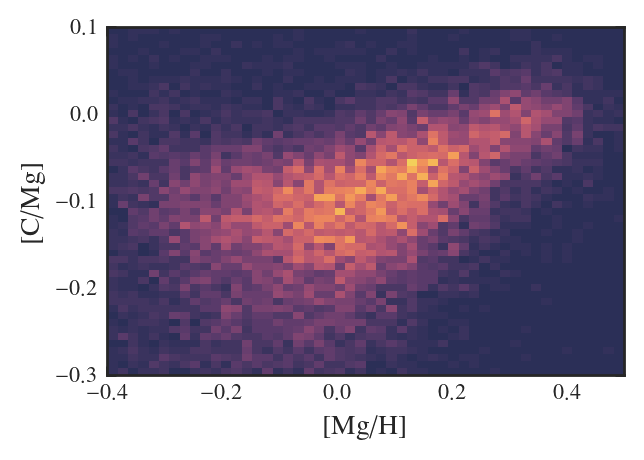

In [31]:
plt.hist2d(df.MG_H, df.C_MG, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

Text(0, 0.5, '[C/Mg]')

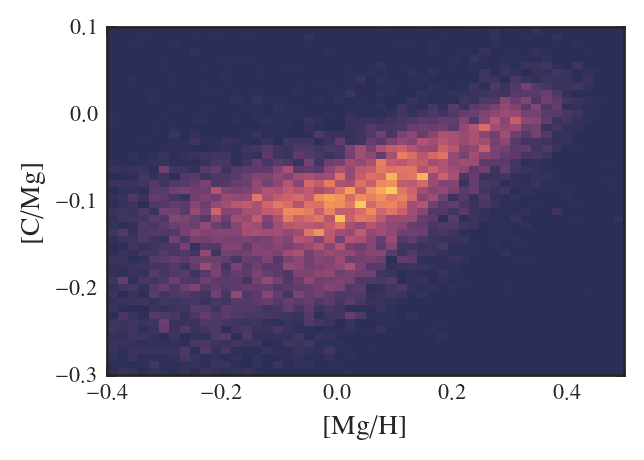

In [32]:
plt.hist2d(df.MG_H_ANN, df.C_H_ANN - df.MG_H_ANN, 50, range=([-0.4, 0.5], [-0.3, 0.1]));
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

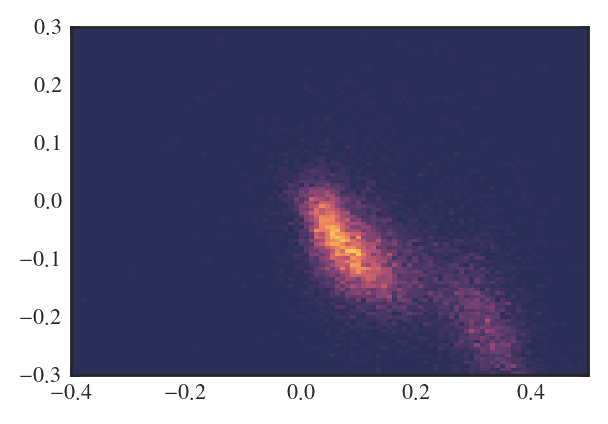

In [33]:
plt.hist2d(df.MG_FE, df.C_MG, 100, range=([-0.4, 0.5], [-0.3, 0.3]));


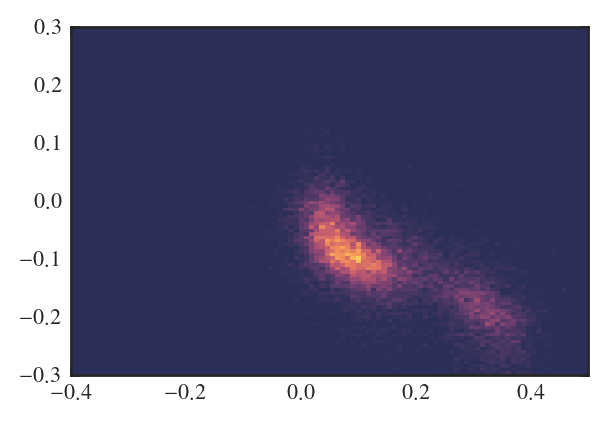

In [34]:
plt.hist2d(df.MG_FE, df.C_H_ANN - df.MG_H_ANN, 100, range=([-0.4, 0.5], [-0.3, 0.3]));


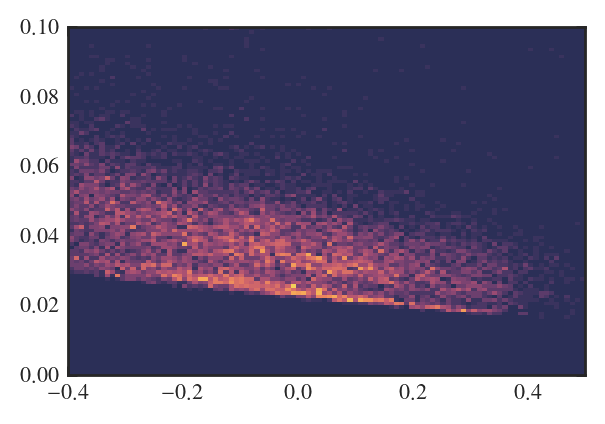

In [37]:
plt.hist2d(df.FE_H, df.C_MG_ERR, 100, range=([-0.4, 0.5], [0, 0.1]));


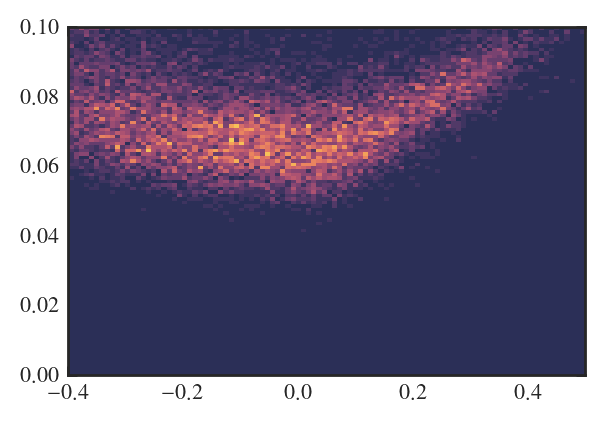

In [38]:
plt.hist2d(df.FE_H, df.C_H_ERR_ANN + df.MG_H_ERR_ANN, 100, range=([-0.4, 0.5], [0, 0.1]));


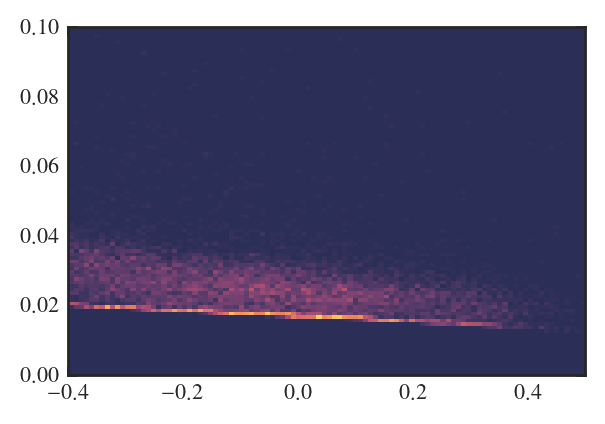

In [39]:
plt.hist2d(df.FE_H, df.MG_H_ERR, 100, range=([-0.4, 0.5], [0, 0.1]));


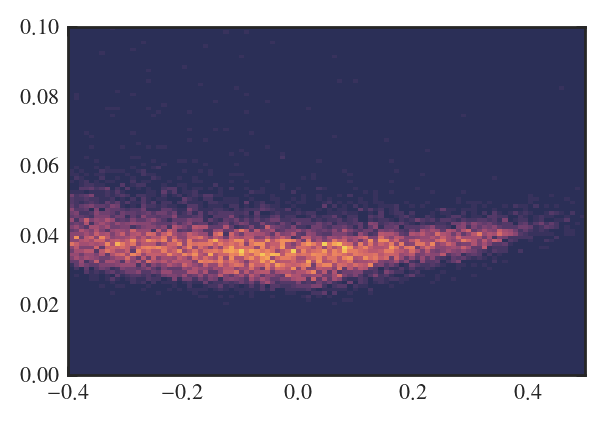

In [40]:
plt.hist2d(df.FE_H, df.MG_H_ERR_ANN, 100, range=([-0.4, 0.5], [0, 0.1]));
